In [1]:
# setup
import gc
from typing import Optional
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix
import torchaudio
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from model import ShortChunkCNN_Res

# TODO: change the file path
FILE_DIR = "./nsynth-subtrain/audio"
LABEL_PATH = "./nsynth-subtrain/examples.json"
VAL_FILE_DIR = "./nsynth-valid/audio"
VAL_LABEL_PATH = "./nsynth-valid/examples.json"
RANDOM_SEED = 0
LABEL_NAMES = {0: "bass", 1: "brass", 2: "flute", 3: "guitar", 4: "keyboard", 5: "mallet", 6: "organ", 7: "reed", 8: "string", 9: "synth_lead", 10: "vocal"}


In [2]:
# load file
df = pd.read_json(LABEL_PATH, orient='index')
print(df.columns)
display(df.head())

# load valid file
val_df = pd.read_json(VAL_LABEL_PATH, orient='index')
print(val_df.columns)


Index(['note', 'sample_rate', 'pitch', 'instrument_source',
       'instrument_family_str', 'instrument_str', 'note_str', 'qualities_str',
       'instrument_source_str', 'velocity', 'instrument_family', 'instrument',
       'qualities'],
      dtype='object')


,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities
bass_synthetic_022-108-127,89262,16000,108,2,bass,bass_synthetic_022,bass_synthetic_022-108-127,"[bright, distortion]",synthetic,127,0,321,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
bass_synthetic_050-108-075,272731,16000,108,2,bass,bass_synthetic_050,bass_synthetic_050-108-075,"[distortion, nonlinear_env]",synthetic,75,0,540,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
bass_synthetic_057-108-100,284902,16000,108,2,bass,bass_synthetic_057,bass_synthetic_057-108-100,"[distortion, nonlinear_env]",synthetic,100,0,583,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]"
bass_synthetic_017-108-050,37332,16000,108,2,bass,bass_synthetic_017,bass_synthetic_017-108-050,[long_release],synthetic,50,0,249,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
bass_synthetic_131-108-100,225176,16000,108,2,bass,bass_synthetic_131,bass_synthetic_131-108-100,"[bright, distortion]",synthetic,100,0,909,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


Index(['note_str', 'sample_rate', 'qualities_str', 'instrument_source',
       'instrument_family_str', 'instrument_family', 'note',
       'instrument_source_str', 'qualities', 'pitch', 'instrument_str',
       'instrument', 'velocity'],
      dtype='object')


## Task3: Deep Learning Model

### Load data

In [3]:
# load files
wavs_list = []
for filename in tqdm(df.index):
    filepath = f"{FILE_DIR}/{filename}.wav"
    wav, sr = torchaudio.load(filepath, normalize=True)
    wavs_list.append(wav.numpy())

wavs = np.concatenate(wavs_list, axis=0)
del wavs_list
gc.collect()

print(wavs.shape)


100%|██████████| 48037/48037 [01:40<00:00, 478.51it/s] 


(48037, 64000)


In [4]:
# load valid files
val_wavs_list = []
for filename in tqdm(val_df.index):
    filepath = f"{VAL_FILE_DIR}/{filename}.wav"
    wav, sr = torchaudio.load(filepath, normalize=True)
    val_wavs_list.append(wav.numpy())

val_wavs = np.concatenate(val_wavs_list, axis=0)
del val_wavs_list
gc.collect()

print(val_wavs.shape)


100%|██████████| 12678/12678 [03:47<00:00, 55.84it/s]


(12678, 64000)


In [5]:
%whos

Variable               Type            Data/Info
------------------------------------------------
DataLoader             type            <class 'torch.utils.data.dataloader.DataLoader'>
Dataset                type            <class 'torch.utils.data.dataset.Dataset'>
FILE_DIR               str             ./nsynth-subtrain/audio
LABEL_NAMES            dict            n=11
LABEL_PATH             str             ./nsynth-subtrain/examples.json
Optional               _SpecialForm    typing.Optional
RANDOM_SEED            int             0
ShortChunkCNN_Res      type            <class 'model.ShortChunkCNN_Res'>
VAL_FILE_DIR           str             ./nsynth-valid/audio
VAL_LABEL_PATH         str             ./nsynth-valid/examples.json
accuracy_score         function        <function accuracy_score at 0x7b9906393eb0>
confusion_matrix       function        <function confusion_matrix at 0x7b99063fc040>
datetime               type            <class 'datetime.datetime'>
df                    

In [6]:
# DEVICE: GPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-params
EPOCHS = 10
PATIENCE = 5
BATCH_SIZE = 32  # 64
LR = 1e-5  # 1e-5

# for model
N_CHANNELS = 128  # 256
N_FFT = 2048
HOP_LENGTH = 512  # 1024


In [7]:
class MyDataset(Dataset):
    def __init__(self, wavs: np.array, log: pd.DataFrame):
        self.wavs = torch.tensor(wavs, dtype=torch.float32)
        self.target = torch.tensor(log["instrument_family"].values, dtype=torch.int64)
        x_qual = np.array(log["qualities"].apply(lambda x: np.array(x)).tolist())
        x_npv = log[["note",	"pitch", "velocity"]].values
        self.metadata = torch.tensor(np.hstack((x_qual, x_npv)), dtype=torch.float32)

    def __len__(self):
        return self.wavs.shape[0]
    
    def __getitem__(self, idx):
        return self.wavs[idx], self.target[idx], self.metadata[idx]


In [8]:
def save_checkpoint(model, path, verbose = False):
    postfix = datetime.now().strftime("%m%d-%H-%M")
    if path is None:
        path = f"DL_ShortChunkCNN_{postfix}.pt"
    torch.save(model.state_dict(), path)
    if verbose:
        print(f"model successfully saved to {path}")

### Train DL model (ShortChunkCNN_Res)

In [9]:
def train(
        train_wavs: np.array, 
        train_log: pd.DataFrame, 
        valid_wavs: np.array, 
        valid_log: pd.DataFrame,
        with_meta: bool = False,
        model_path: Optional[str] = None,
        model_params: Optional[dict] = None, 
        verbose: bool = True
    ):

    # Training and Validation Record
    train_loss_list = []
    valid_loss_list = []

    # Early Stopping
    best_acc = 0
    cnt = 0

    # Training and Valid Dataset
    print("Prepare dataloader...")
    train = MyDataset(train_wavs, train_log)
    valid = MyDataset(valid_wavs, valid_log)
    
    # Training and Valid DataLoader
    train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

    # Model    
    model = ShortChunkCNN_Res(with_meta=with_meta, **model_params) if model_params else ShortChunkCNN_Res(with_meta=with_meta)

    # Optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # Training Start!!!
    print("Training Start!!!")
    for epoch in tqdm(range(EPOCHS), disable=(not verbose)):

        model.to(DEVICE)
        model.train()

        total_loss = 0
        train_true = torch.tensor([])
        train_pred = torch.tensor([])

        # Training with batches
        for i, (train_wavs, train_target, train_metadata) in enumerate(train_dataloader):
            train_wavs = train_wavs.to(DEVICE)
            train_target = train_target.to(DEVICE)
            train_metadata = train_metadata.to(DEVICE)

            # Train
            optimizer.zero_grad()
            if with_meta:
                output = model(train_wavs, train_metadata)
            else:
                output = model(train_wavs)
            loss = loss_fn(output, train_target)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate Score
            train_target = train_target.cpu()
            output_label = torch.argmax(output, dim=-1).cpu()
            train_true = torch.cat([train_true, train_target])
            train_pred = torch.cat([train_pred, output_label])

            # Delete Var
            del train_wavs, train_target, train_metadata, output, output_label
            gc.collect()

        train_loss_list.append(total_loss)
        train_top1_acc = accuracy_score(train_true, train_pred)

        # validation
        valid_total_loss = 0
        model.eval()
        valid_true = torch.tensor([])
        valid_pred = torch.tensor([])

        for j, (valid_wavs, valid_target, valid_metadata) in enumerate(valid_dataloader):
            valid_wavs = valid_wavs.to(DEVICE)
            valid_target = valid_target.to(DEVICE)
            valid_metadata = valid_metadata.to(DEVICE)

            if with_meta:
                output = model(valid_wavs, valid_metadata)
            else:
                output = model(valid_wavs)

            loss = loss_fn(output, valid_target)
            valid_total_loss += loss.item()

            # Calculate Score
            valid_target = valid_target.cpu()
            output_label = torch.argmax(output, dim=-1).cpu()
            valid_true = torch.cat([valid_true, valid_target])
            valid_pred = torch.cat([valid_pred, output_label])

            # Delete Var
            del valid_wavs, valid_target, valid_metadata, output, output_label
            gc.collect()

        valid_loss_list.append(valid_total_loss)
        valid_top1_acc = accuracy_score(valid_true, valid_pred)

        print(f"epoch {epoch+1}: train loss: {total_loss}, train top1 acc: {train_top1_acc} || valid loss: {valid_total_loss}, valid top1 acc: {valid_top1_acc}")

        # for early stopping
        if valid_top1_acc <= best_acc:
            cnt += 1
            if cnt >= PATIENCE:
                print(f"Early Stopping at epoch: {epoch+1}, the best valid acc = {best_acc}")
        else:
            best_acc = valid_top1_acc
            cnt = 0
            save_checkpoint(model, model_path)
        
        # Delete Var
        del train_true, train_pred, valid_true, valid_pred
        gc.collect()
    
    best_model = ShortChunkCNN_Res(with_meta=with_meta, **model_params) if model_params else ShortChunkCNN_Res(with_meta=with_meta)
    best_model.load_state_dict(torch.load(model_path))

    # Clear GPU memory
    torch.cuda.empty_cache()

    return best_model


def test(
        test_wavs: np.array, 
        test_log: pd.DataFrame, 
        model: ShortChunkCNN_Res,
        with_meta: bool = False,
        verbose: bool = True
    ):

    # Test Dataset and DataLoader
    test = MyDataset(test_wavs, test_log)
    test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    loss_fn = nn.CrossEntropyLoss()

    # test start
    model.to(DEVICE)
    model.eval()
    test_total_loss = 0
    test_true = torch.tensor([])
    test_pred = torch.tensor([])
    test_pred_p = torch.tensor([])
    with torch.no_grad():
        for test_wavs, test_target, test_metadata in tqdm(test_dataloader, disable=(not verbose)):
            test_wavs = test_wavs.to(DEVICE)
            test_target = test_target.to(DEVICE)
            test_metadata = test_metadata.to(DEVICE)

            if with_meta:
                output = model(test_wavs, test_metadata)
            else:
                output = model(test_wavs)

            loss = loss_fn(output, test_target)
            test_total_loss += loss.item()

            # Calculate Score
            test_target = test_target.cpu()
            output_label = torch.argmax(output, dim=-1).cpu()
            output = output.cpu()
            test_true = torch.cat([test_true, test_target])
            test_pred = torch.cat([test_pred, output_label])
            test_pred_p = torch.cat([test_pred_p, output])

            # Delete Var
            del test_wavs, test_target, test_metadata, output, output_label
            gc.collect()

    test_top1_acc = accuracy_score(test_true, test_pred)
    test_top3_acc = top_k_accuracy_score(test_true, test_pred_p, k=3, labels=list(LABEL_NAMES.keys()))

    print(f"Top 1 Accuracy: {test_top1_acc:.4f}")
    print(f"Top 3 Accuracy: {test_top3_acc:.4f}")

    if verbose:
        cmx = confusion_matrix(test_true, test_pred)
        plt.figure(figsize=(8, 4))
        sns.heatmap(cmx, annot=True, fmt='d', cmap='Blues', xticklabels=LABEL_NAMES.values(), yticklabels=LABEL_NAMES.values())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

    return test_true, test_pred


### Train Model

In [10]:
# model 1: without metadata / model 2: with metadata
# model_path = "DL_ShortChunkCNN_Res_1.pt"
model_path = "DL_ShortChunkCNN_Res_2.pt"

# TODO: un-comment this line for training
# model1 = train(wavs, df, val_wavs, val_df, with_meta=False, model_path=model_path)
model2 = train(wavs, df, val_wavs, val_df, with_meta=True, model_path=model_path)


Prepare dataloader...
Training Start!!!


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1: train loss: 3478.065853834152, train top1 acc: 0.23209192913795615 || valid loss: 870.4528849124908, valid top1 acc: 0.43547878214229374


 10%|█         | 1/10 [04:29<40:24, 269.40s/it]

epoch 2: train loss: 3075.6895678043365, train top1 acc: 0.5763265815933551 || valid loss: 773.4474556446075, valid top1 acc: 0.6094021138980912


 20%|██        | 2/10 [08:58<35:54, 269.35s/it]

epoch 3: train loss: 2700.073987841606, train top1 acc: 0.7915565085246788 || valid loss: 737.8463896512985, valid top1 acc: 0.708786874901404


 30%|███       | 3/10 [13:27<31:22, 268.88s/it]

epoch 4: train loss: 2550.0203660726547, train top1 acc: 0.8852551158482004 || valid loss: 720.1947889328003, valid top1 acc: 0.751616974286165


 40%|████      | 4/10 [17:55<26:52, 268.75s/it]

epoch 5: train loss: 2454.592119216919, train top1 acc: 0.9381102067156567 || valid loss: 714.3064067363739, valid top1 acc: 0.7562707051585423


 60%|██████    | 6/10 [26:48<17:49, 267.43s/it]

epoch 6: train loss: 2414.317271590233, train top1 acc: 0.9557216312425838 || valid loss: 723.4060825109482, valid top1 acc: 0.7298469790187727
epoch 7: train loss: 2396.90429520607, train top1 acc: 0.9637779211857527 || valid loss: 705.3192180395126, valid top1 acc: 0.7689698690645212


 70%|███████   | 7/10 [31:18<13:24, 268.10s/it]

epoch 8: train loss: 2381.8221868276596, train top1 acc: 0.970335366488332 || valid loss: 699.9088374376297, valid top1 acc: 0.7844297207761477


 90%|█████████ | 9/10 [40:15<04:28, 268.26s/it]

epoch 9: train loss: 2373.4270284175873, train top1 acc: 0.9750817078501988 || valid loss: 719.1537271738052, valid top1 acc: 0.741994005363622


100%|██████████| 10/10 [44:41<00:00, 268.16s/it]

epoch 10: train loss: 2365.994400501251, train top1 acc: 0.9779128588379791 || valid loss: 707.1910732984543, valid top1 acc: 0.76873323868118


In [12]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 352292 KiB |   1167 MiB |  53900 GiB |  53900 GiB |
|       from large pool | 335728 KiB |   1150 MiB |  53553 GiB |  53553 GiB |
|       from small pool |  16564 KiB |     18 MiB |    347 GiB |    347 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 352292 KiB |   1167 MiB |  53900 GiB |  53900 GiB |
|       from large pool | 335728 KiB |   1150 MiB |  53553 GiB |

100%|██████████| 397/397 [00:49<00:00,  8.09it/s]


Top 1 Accuracy: 0.7844
Top 3 Accuracy: 0.9243


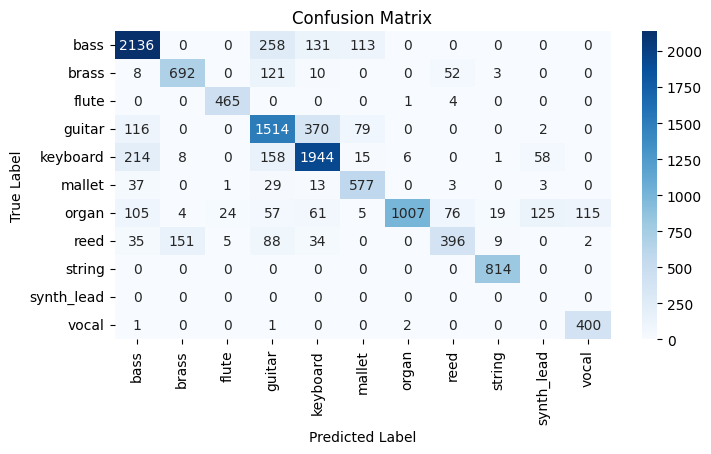

(tensor([ 4.,  0.,  0.,  ..., 10.,  0.,  4.]),
 tensor([ 4.,  0.,  0.,  ..., 10.,  0.,  4.]))

In [11]:
# model_path = "DL_ShortChunkCNN_Res_1.pt"
# model1 = ShortChunkCNN_Res(with_meta=False)
# model1.load_state_dict(torch.load(model_path))
# test(val_wavs, val_df, model1, with_meta=False)

model_path = "DL_ShortChunkCNN_Res_2.pt"
model2 = ShortChunkCNN_Res(with_meta=True)
model2.load_state_dict(torch.load(model_path))
test(val_wavs, val_df, model2, with_meta=True)